<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Base" data-toc-modified-id="Base-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Base</a></span><ul class="toc-item"><li><span><a href="#Base-dataset" data-toc-modified-id="Base-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Base dataset</a></span></li><li><span><a href="#Create-index" data-toc-modified-id="Create-index-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create index</a></span></li></ul></li></ul></div>

К нам обратился заказчик, предположительно маркет-плейс, который желает разработать систему автоматической редакции товаров. Он очень заботится о секретности, так что передал нам данные в зашифрованном виде - в форме обеличенных векторов. На основе базы векторов и некоторой выборки, где к набору векторов экспертами заказчика проставлены наиболее подходящими векторыми из общей базы предлагается построить рекомендательную систему, подбирающую 5 аналогичных векторов.

Дано: 
 Два множества объектов: A и B. Каждый объект в множества описывается какими-то признаками.

Желаемый результат: 
 Для каждого объекта из множества A найти один или несколько объектов из B, которые близки к нему по некоторой заданной метрике.


* A и B могут быть одним и тем же множеством
** Можем и не найти ни одноетствия 
го соотвЗадача: 
+ 
разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.csv+ 

оценить качество алгоритма по метрике accuracy@5

(*) деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько поаров.

етствия


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import faiss
from faiss import write_index, read_index
from tqdm.notebook import tqdm
from tqdm import trange
import time
import winsound
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend, dump, load

from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
from imblearn.over_sampling import SMOTE, ADASYN

# Загрузка датасета

In [2]:
df_base = pd.read_csv("base.csv", index_col=0)

Напишем функцию для разведочного анализа

In [3]:
def make_eda(df):
    # Просмотр первых нескольких строк датасета
    display(df.head())
    # Размер датасета
    print("Размер датасета:", df.shape)
    # Описание данных
    display(df.describe())
    # Проверка наличия пропущенных значений
    print("Количество пропущенных значений по столбцам:")
    display(df.isnull().sum())
    print("Количество дубликатов:")
    print(df.duplicated( keep='first').sum())
    # Гистограмма для числовых столбцов
    numeric_cols = df.columns
    # Построение корреляционной матрицы
    find_top10(df)

In [4]:
#Подфункция для проверки столбцов с высокой взаимной корреляцией
def find_top10(matrix):
    cx=matrix.corr().round(3)
    #Так как матрица будет огромна, выведем только максимальные значения коэффициентов корреляции
    top=[]
    bot=[]
    for i in range(len(cx.columns)):
        a=np.array(cx.iloc[i,:])
        sorted_index_array = np.argsort(a)
        sorted_top = a[sorted_index_array][-2:-1]
        sorted_bottom = a[sorted_index_array][:1]
        top.append(sorted_top)
        bot.append(sorted_bottom)
    corz=pd.DataFrame(columns=['tops','bots'])
    corz['tops']=list(top)
    corz['bots']=list(bot)
    print("Максимальная положительная корреляция:",corz['tops'].max())
    print("Минимальная отрицательная корреляция:",corz['bots'].min())

In [5]:
#Познакомимся с нашей базой
make_eda(df_base)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


Размер датасета: (2918139, 72)


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


Количество пропущенных значений по столбцам:


0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

Количество дубликатов:
0
Максимальная положительная корреляция: [0.176]
Минимальная отрицательная корреляция: [-0.223]


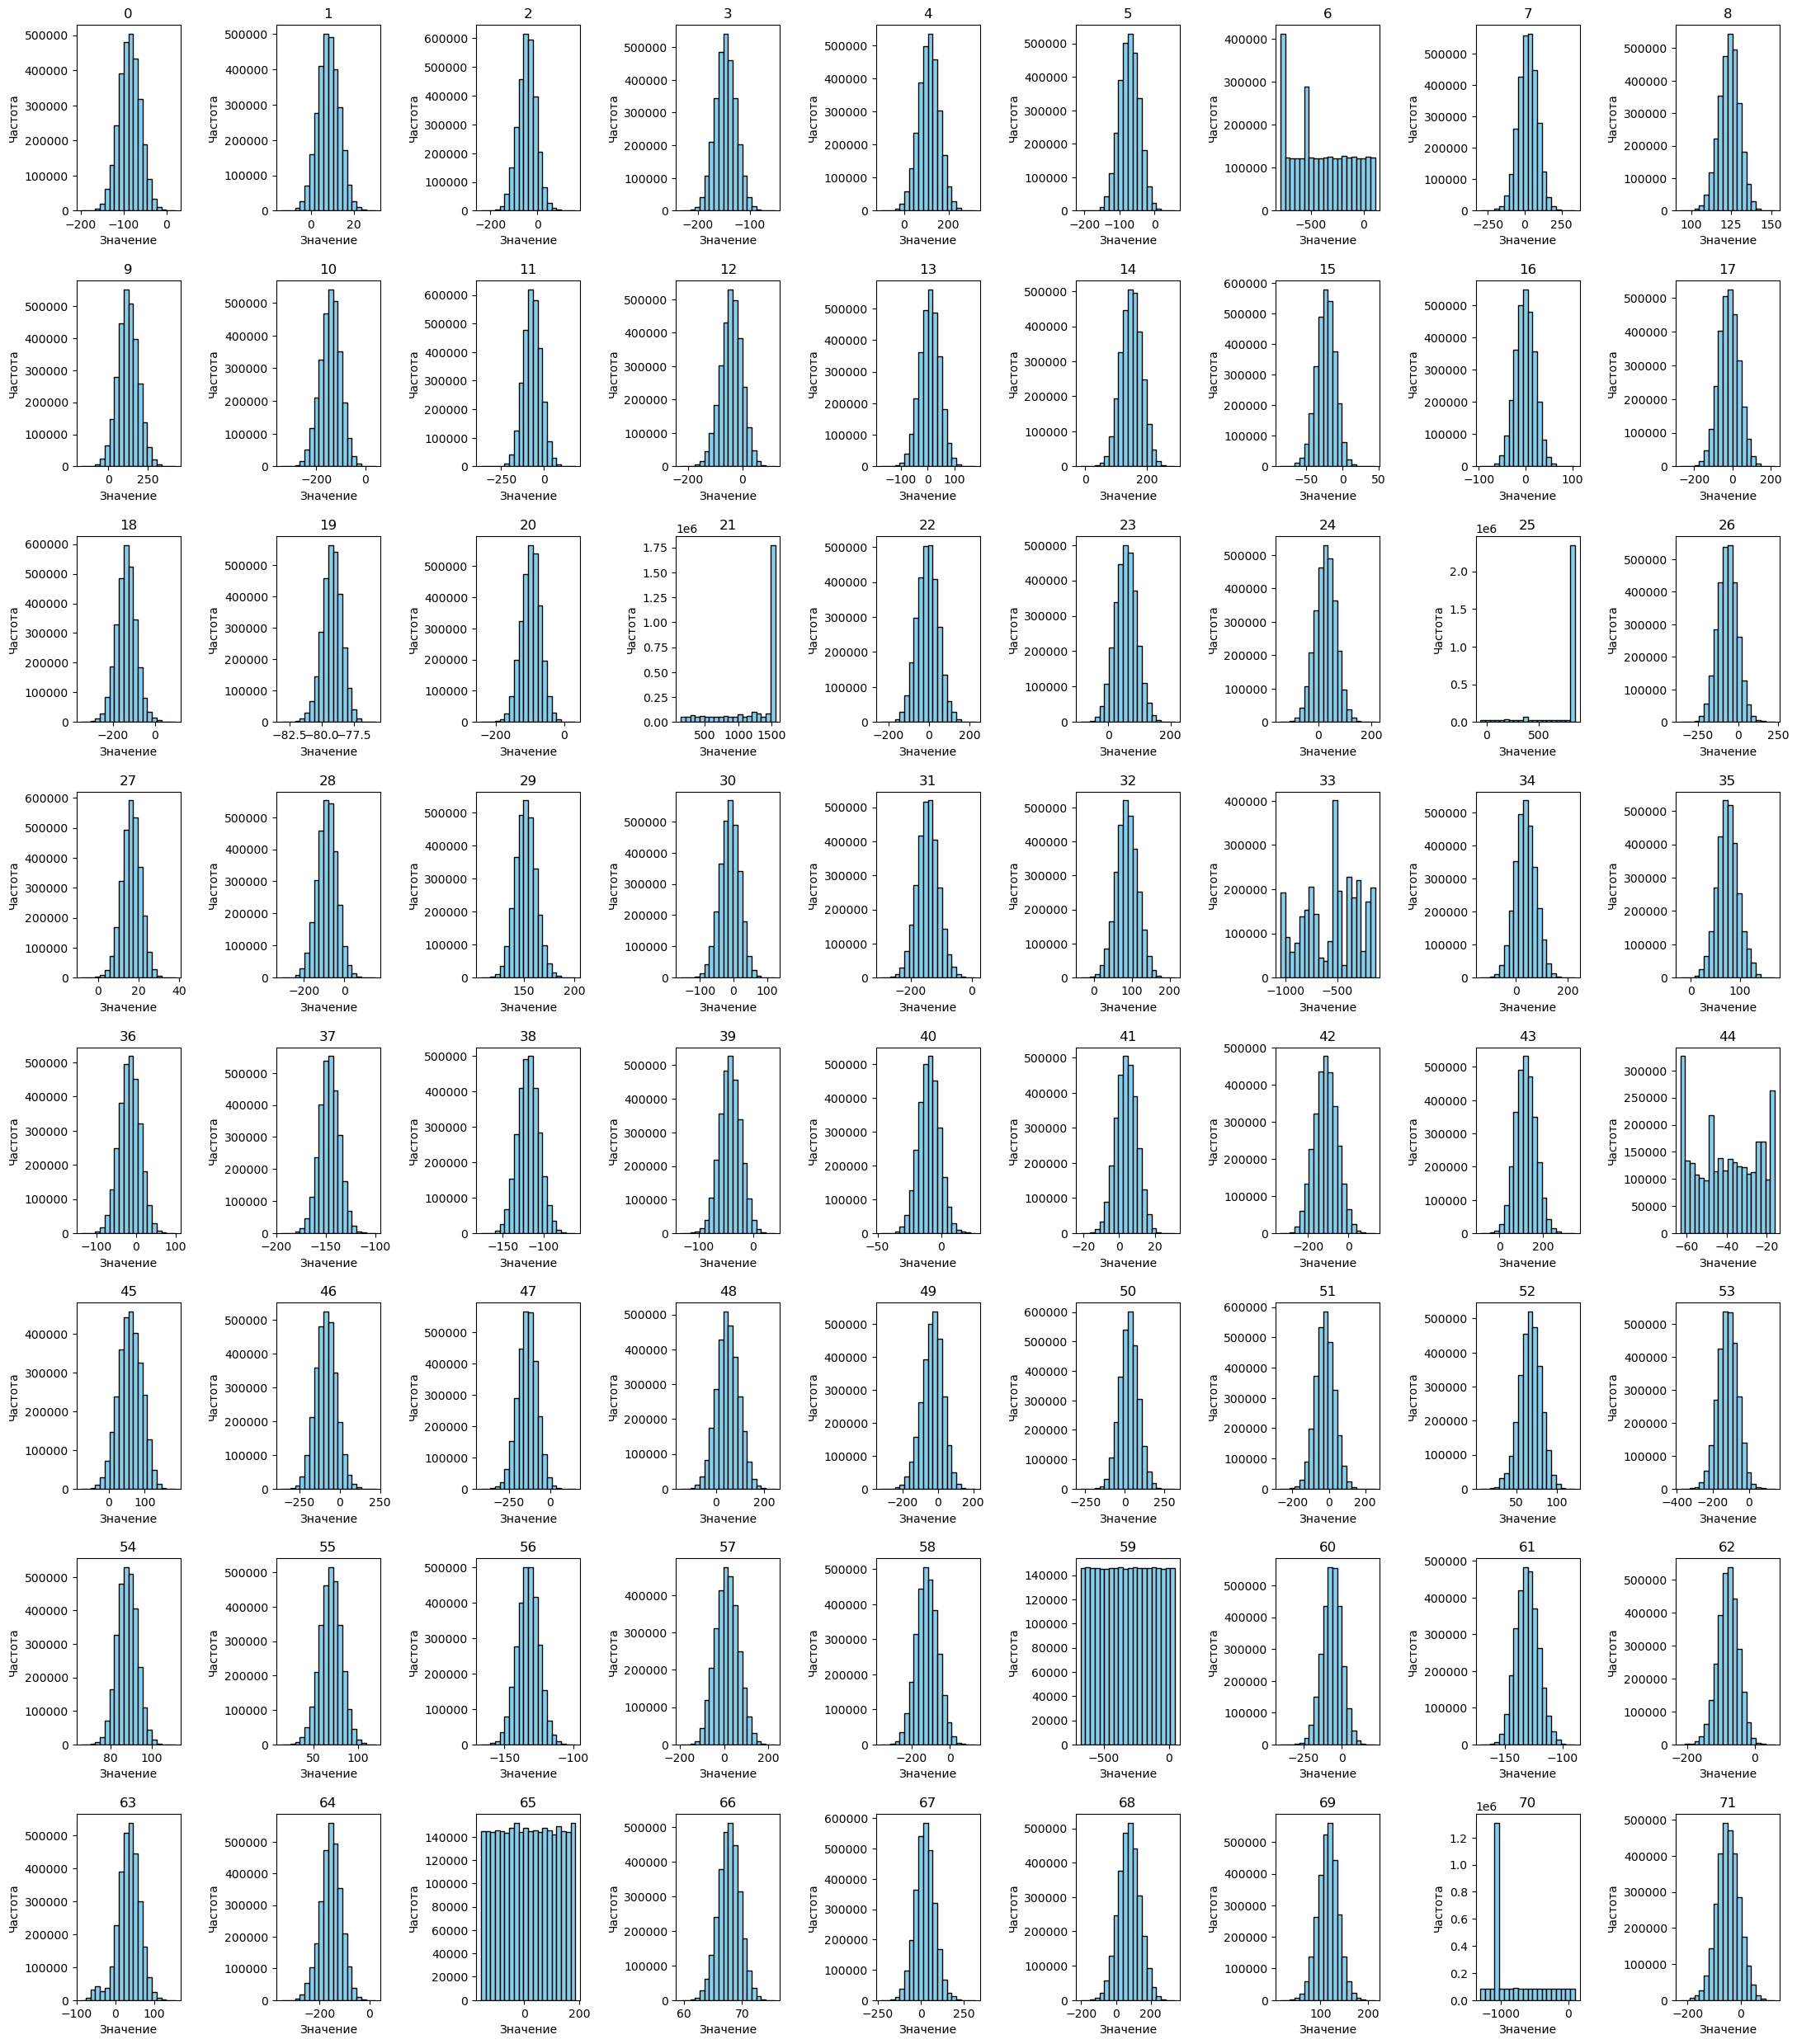

In [6]:
#Посмотрим теперь на гистограммы всех наших переменных

# Создание матрицы графиков размером 8x9
fig, axs = plt.subplots(8, 9, figsize=(22, 25))

# Итерация по столбцам датасета и построение гистограммы для каждого столбца
for i, column in enumerate(df_base.columns):
    # Вычисление индексов подматрицы для текущего столбца
    row = i // 9
    col = i % 9
    
    # Построение гистограммы
    axs[row, col].hist(df_base[column], bins=20, color='skyblue', edgecolor='black')
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Значение')
    axs[row, col].set_ylabel('Частота')

# Установка размещения заголовков и межпространствия между графиками
fig.tight_layout(pad=1.5)

# Отображение графиков
plt.show()

**Вывод**

Проведённый разведочных анализ данных позволяет вынести следующие суждения о датасете:
- Данные высокого качества, не имеют пропусков и дубликатов.
- Взаимная корреляция данных пренебрежительно мала.
- В большинстве своём данные распределены нормально, но срадние их величины сильно разнятся, вдобавок наблюдается существенные выбросы. Необходимо провести стандартизацию.
- Данные в колонках ['6','21','25','33','44','59','65','70'] явно имеют какую-то категориальную природу, потому мы попробуем исключить их из моделирования, так как считать векторные расстояния по категориальным и сильно дискретным переменным - дело неблагодарное.

# Предобработка данных

In [7]:
# Как и запланировали выкинем столбцы с данными, распределение которых разительно отличается от нормального.
df_base=df_base.drop(['6','21','25','33','44','59','65','70'], axis=1)

Проведём стандартизацию данных. В ходе своих опытов я перепробовал много разных функций стандартизации. Они разделились на две категории. К первой отошли те, кто делал данными непригодными.
Ко второй - несколько стандартизаторов, которые показали практически одинаковые результаты, неотличимые на глаз от StandardScaler. Его мы и будем использовать.

In [8]:
# Проведём стандартизацию данных с помощью StandardScaler
sc=StandardScaler()
sc.fit(df_base)
df_base_sc=sc.transform(df_base)
print('StandardScaler- is fit-transformed')
winsound.Beep(200, 500)

StandardScaler- is fit-transformed


In [9]:
df_base = pd.read_csv("base.csv", index_col=0)
df_base=df_base.drop(['6','21','25','33','44','59','65','70'], axis=1)

# Создание индекса

Теперь, когда наши данные подготовлены, мы построим поисковый индекс на основе библиотеки faiss, который позволит нам найти вектора-соседи для каждого запроса.

In [10]:
#размерость возьмём как у нашей базы
dims = df_base.shape[1]
#количесво ячеек вычислим как корень из количества наблюдений
n_cells = round(dims**0.5) 
# Строить индекс будем с использованием графического процессора, для ускорения
res = faiss.StandardGpuResources()
m = 8
assert dims % m == 0
nbits = 256  # number of bits per subquantizer, k* = 2**nbitsm

#Построим индекс
quantizer = faiss.IndexPQ(dims, m, nbits)
index_flat = faiss.IndexIVFFlat(quantizer, dims, n_cells)
#Адаптируем его для видео-процессора
idx_l2 = faiss.index_cpu_to_gpu(res, 0, index_flat)

In [11]:
#Построим индекс на выборке из 200 тыс. значений
idx_l2.train(np.ascontiguousarray(df_base_sc[:200000,:]).astype('float32'))
#Проиндексируем всю базу
idx_l2.add(np.ascontiguousarray(df_base_sc).astype('float32'))
winsound.Beep(200, 500)
print('Index is ready')


Index is ready


In [12]:
#Созданим словарь, чтобы потом можно было находить значения в исходной базе по индексу.
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}


# Поиск соседений для обучающей выборки

Теперь, когда у нас есть индекс, мы используем его для того, чтобы подобрать соседей из общей базы, для запросов в тестовой выборке, по которым мы имеем выбранных экспертом "подходящих соседей". С использованием этих экспертных оценок мы сможем понять насколько хорошо побирает соседений наш индекс, а точнее в скольки процентах случаев среди 5 предложенных соседей попадается тот самый, которого выбрали эксперты.

In [13]:
df_train = pd.read_csv("train.csv", index_col=0)

In [14]:
make_eda(df_train)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


Размер датасета: (100000, 73)


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


Количество пропущенных значений по столбцам:


0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64

Количество дубликатов:
0
Максимальная положительная корреляция: [0.088]
Минимальная отрицательная корреляция: [-0.066]


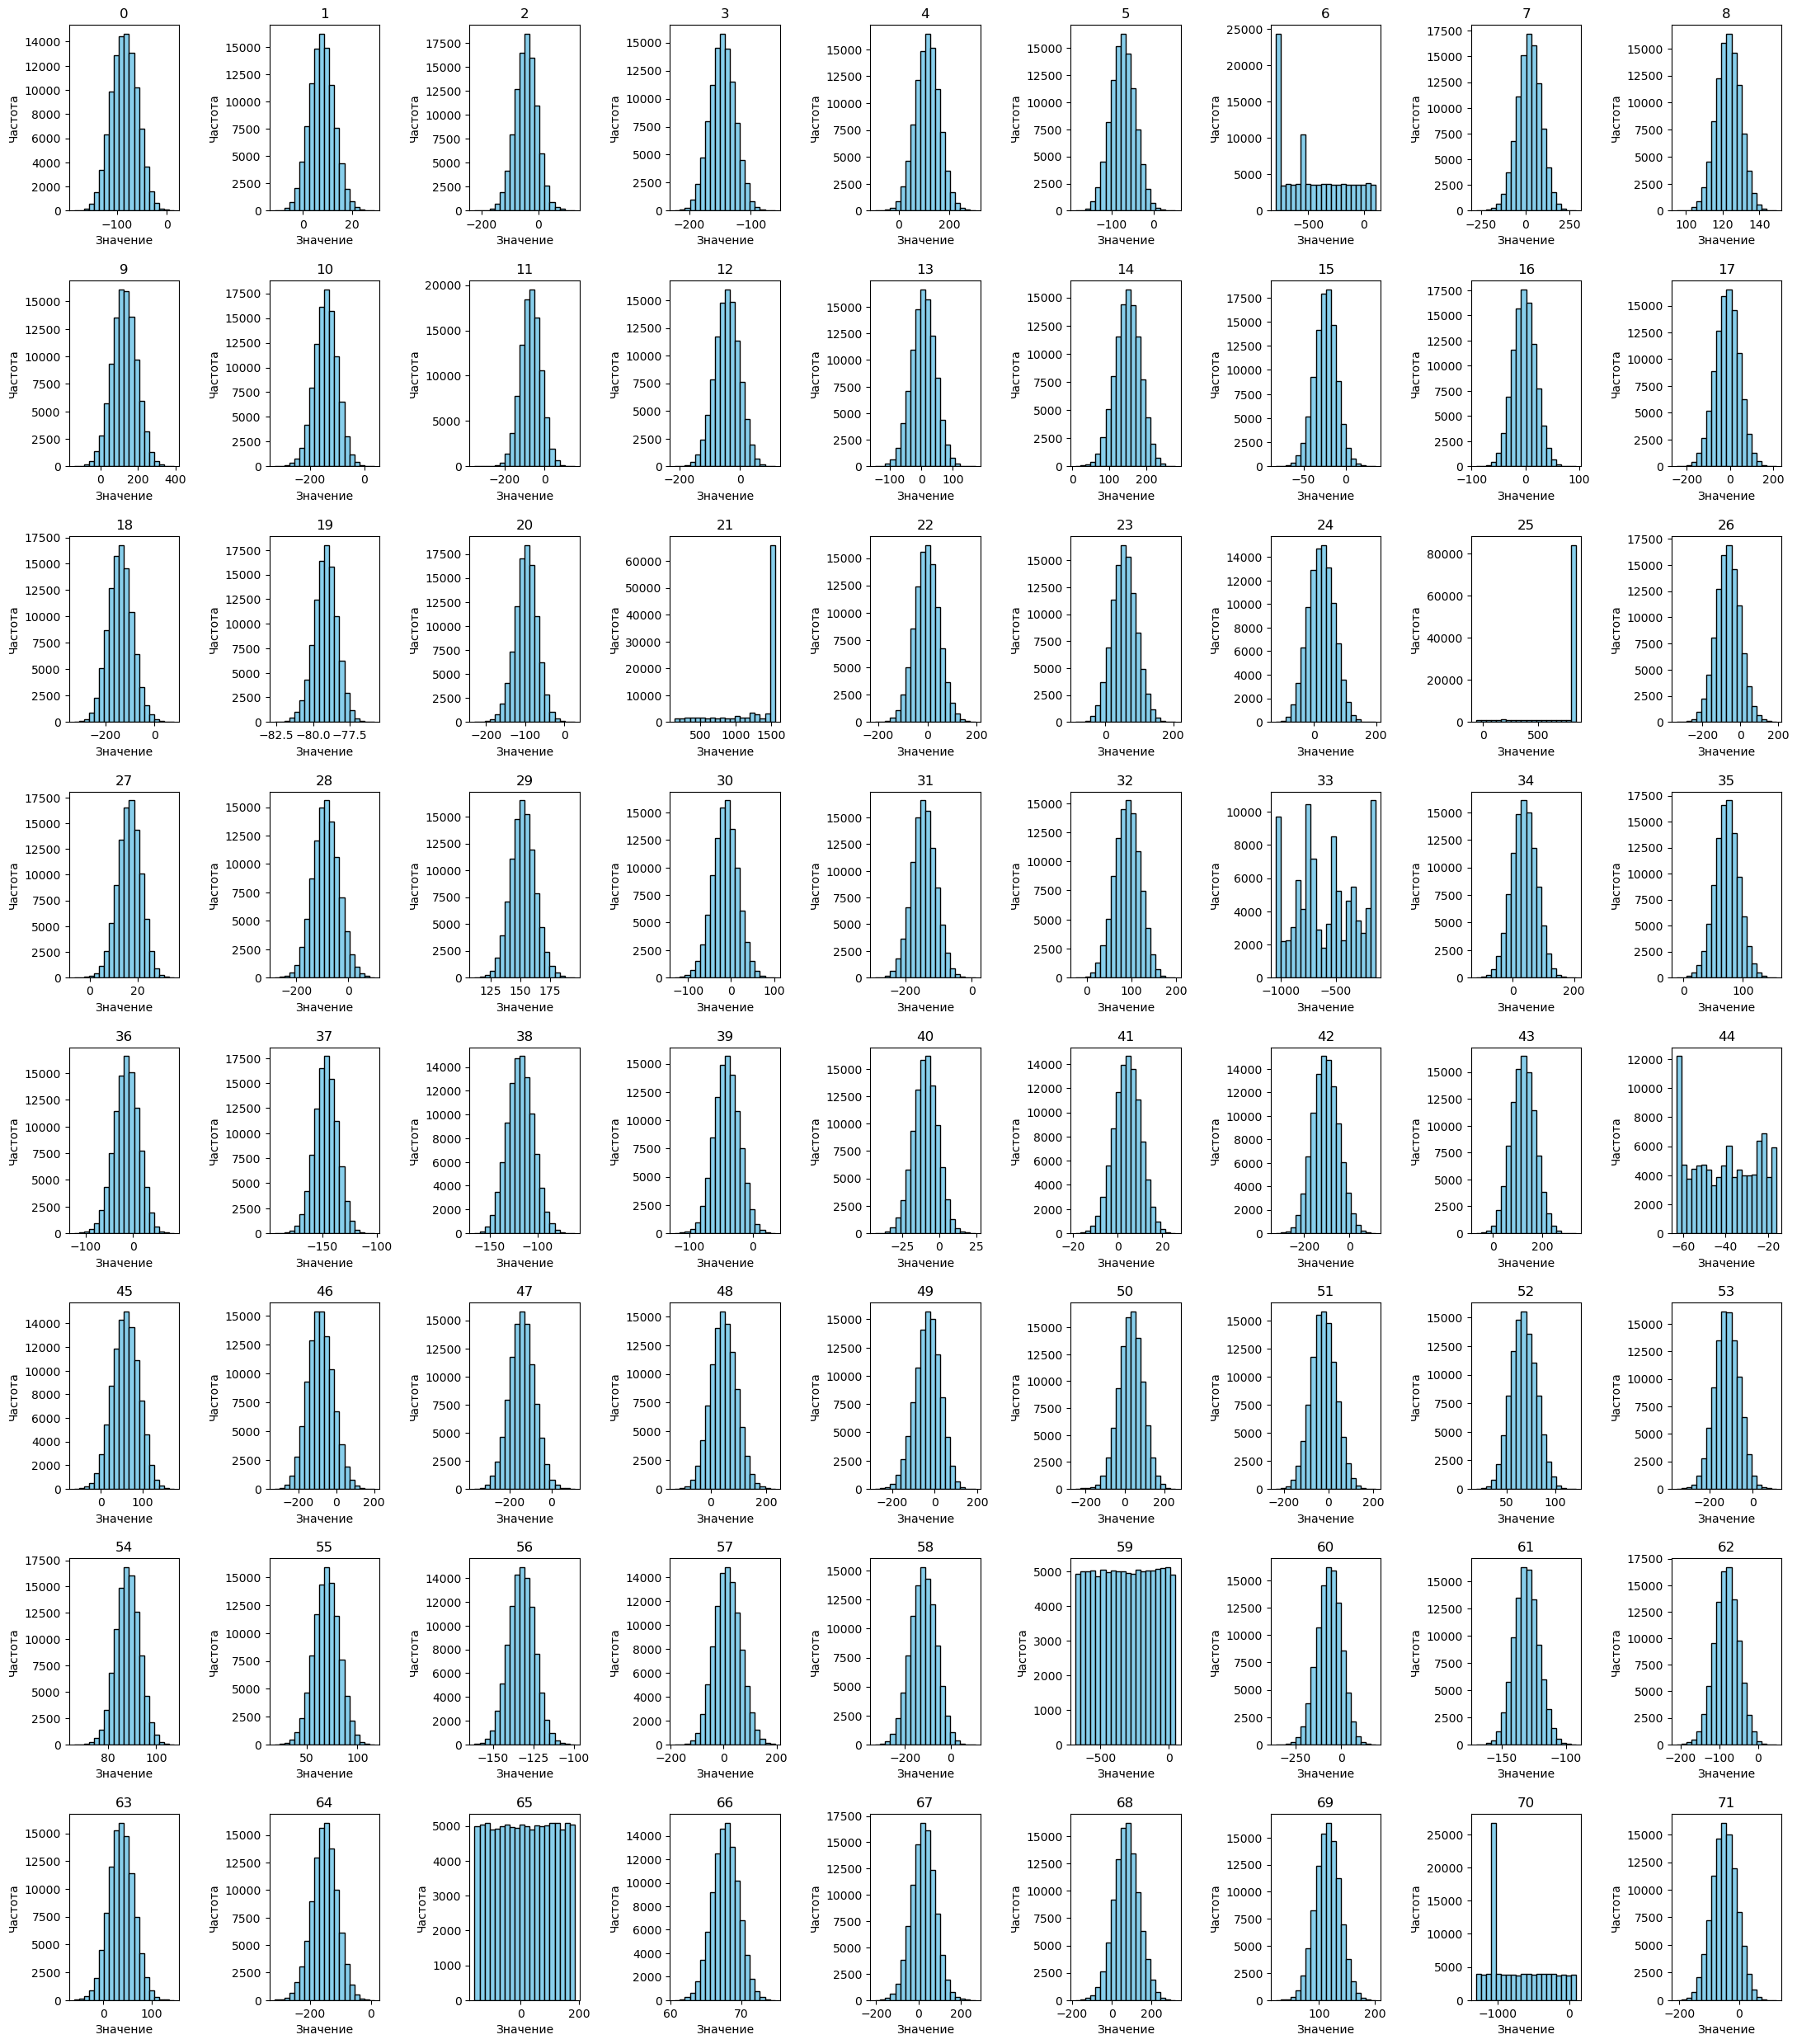

In [15]:
#Посмотрим теперь на гистограммы всех наших переменных

# Создание матрицы графиков размером 8x9
fig, axs = plt.subplots(8, 9, figsize=(22, 25))
cl=list(df_train.columns)[:-1]
# Итерация по столбцам датасета и построение гистограммы для каждого столбца
for i, column in enumerate(cl):
    # Вычисление индексов подматрицы для текущего столбца
    row = i // 9
    col = i % 9
    
    # Построение гистограммы
    axs[row, col].hist(df_train[column], bins=20, color='skyblue', edgecolor='black')
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Значение')
    axs[row, col].set_ylabel('Частота')

# Установка размещения заголовков и межпространствия между графиками
fig.tight_layout(pad=1.5)

# Отображение графиков
plt.show()

**Вывод**
Проведённый разведочных анализ данных сказать, что обучающиий набор данных мало чем отличается от базового набора:
- Нет  пропусков и дубликатов.
- Взаимная корреляция тоже отсутствует.
- Числовые признаки также нуждаются в стандартизации.
- Данные в колонках ['6','21','25','33','44','59','65','70'] как и в базовой выборке - явно странные и лучше мы их исключим.

In [16]:
#Удалим столбцы со значениями, непригодными для векторой кластеризации на основе faiss
df_train=df_train.drop(['6','21','25','33','44','59','65','70'], axis=1)

In [17]:
#Сохраним целевую переменную в отдельный список
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [18]:
#Выберем число ячеек, которые наш индекс будет сканировать в рамках выявления соседей
idx_l2.nprobe=40

In [19]:
#Повторим стандартизацию данных
sc.fit(df_train)
df_train_sc=sc.transform(df_train)
#Разделим тренировочную базу на кусочки, чтобы сделать процесс создания индекса более наблюдаемым
batches = np.array_split(df_train_sc, 1000)
start=time.time()
# Запустим поиск соседений для каждого кусочка
results = []
indices = []
for batch in tqdm(batches):
    r, idx = idx_l2.search(np.ascontiguousarray(batch).astype('float32'), 5)
    results.append(r)
    indices.append(idx)

# Объединим кусочки в единые вектора расстояний и индексов
r = np.concatenate(results)
idx = np.concatenate(indices)
end=time.time()
winsound.Beep(200, 500)
print(end-start)

  0%|          | 0/1000 [00:00<?, ?it/s]

123.31305313110352


In [20]:
#Пришла пора оценить точность подобра соседний алгоритмом faiss
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
winsound.Beep(200, 500)
print(100 * acc / len(idx))

71.025


**Вывод**

Итак, в 71% случаев из 5 предложенных алгоритмом соседений, есть именно тот, который разметили эксперте в обучающей базе. Это уже неплохо, но мы попытаемся улучшить этот показатель, применив методы машинного обучения.

# Машинное обучение

## Подготовка данных для машинного обучения

In [21]:
#Первое что нам понадобится - это набор соседей побольше. Ведь если из 5 мы угадываем 71%, то из 100 модель сможет вытащить несколько больше.
start=time.time()
results = []
indices = []
for batch in tqdm(batches):
    #Здесь мы зададим поиск 100 соседей!
    r, idx = idx_l2.search(np.ascontiguousarray(batch).astype('float32'), 100)
    results.append(r)
    indices.append(idx)

# Concatenate the results and indices
r = np.concatenate(results)
idx = np.concatenate(indices)
end=time.time()
winsound.Beep(200, 500)
print(end-start)

  0%|          | 0/1000 [00:00<?, ?it/s]

82.47643876075745


In [22]:
# функция для получения индекса рекомендаций в базовом наборе товаров по индексу FAISS
def get_base_idx(row):
    return base_index[row['idx']]

In [23]:
#созданим новый датафрейм, где будет собирать данные для машинного обучения
#Сначала положим туда индексы, которые нашёл faiss
df_for_ml = pd.DataFrame(idx) 

In [24]:
#Создадим столбец с индексом запроса
df_for_ml['ii']=df_for_ml.index.values.astype('str')
df_for_ml['query_idx']=df_for_ml['ii']+'-query'
value_vars_=list(df_for_ml.columns.values)[:-2]
# Мы можем "расплавить" этот DataFrame в длинный формат, так чтобы каждому запросу соответствовало 100 строк с каждым предложенным соседом
melted_df = pd.melt(df_for_ml, id_vars=['query_idx'], value_vars=value_vars_)

# Поскольку нам не нужен столбец "variable", мы можем его удалить
melted_df = melted_df.drop('variable', axis=1)
melted_df = melted_df.rename(columns={'value': 'idx'})
# Вывести итоговый DataFrame
melted_df.sort_values(by=['query_idx'])

,query_idx,idx
0,0-query,336969
9800000,0-query,269552
7700000,0-query,751217
1500000,0-query,142730
7600000,0-query,200263
...,...,...
6999999,99999-query,2184271
7099999,99999-query,1754491
7199999,99999-query,521686
7399999,99999-query,1446043


In [25]:
#Чтобы модель хорошо предсказывала надо накормить её разнообразными данными, начнём с расстояния до соседа, посчитанного тем же faiss
df_r=pd.DataFrame(r)
df_r['query_idx_r']=df_for_ml['query_idx']
value_vars_=list(df_r.columns.values)[:-1]
# Мы можем "расплавить" этот и DataFrame в длинный формат
melted_r = pd.melt(df_r, id_vars=['query_idx_r'], value_vars=value_vars_)
# Поскольку нам не нужен столбец "variable", мы можем его удалить
melted_r = melted_r.drop('variable', axis=1)
melted_r = melted_r.rename(columns={'value': 'faiss_r'})
melted_r.sort_values(by=['query_idx_r'])

,query_idx_r,faiss_r
0,0-query,9.632658
9800000,0-query,23.706959
7700000,0-query,22.311544
1500000,0-query,14.424289
7600000,0-query,22.267065
...,...,...
6999999,99999-query,48.992912
7099999,99999-query,49.029263
7199999,99999-query,49.036190
7399999,99999-query,49.142860


In [26]:
#Объединим предложенных индексы с предложенными расстояниями
df = pd.concat([melted_df, melted_r], axis=1)
df = df.drop('query_idx_r', axis=1)
df

,query_idx,idx,faiss_r
0,0-query,336969,9.632658
1,1-query,15185,11.057484
2,2-query,1162532,14.511409
3,3-query,1179186,10.019031
4,4-query,631912,0.184657
...,...,...,...
9999995,99995-query,2533298,51.820320
9999996,99996-query,972427,51.150173
9999997,99997-query,2316917,43.593960
9999998,99998-query,483622,6.234782


In [27]:
#Возможно, нам для обучения модели могут хорошую службу сыграть и вектора, харатеризующие записи в базовом датасете
df_train_sc=pd.DataFrame(df_train_sc)
df_train_sc['ii']=df_train_sc.index.values.astype('str')
df_train_sc['query_idx']=df_train_sc['ii']+'-query'
df_train_sc = df_train_sc.drop('ii', axis=1)
df_train_sc

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,query_idx
0,1.218659,2.079877,0.039629,-1.850675,1.587961,-0.486308,0.258787,-2.153763,-1.474397,1.275871,...,-0.182183,-0.791579,1.309634,-0.087262,-1.031430,0.206023,-0.173143,0.906949,0.547062,0-query
1,-0.094858,-0.173152,0.296912,-1.523962,0.189363,-0.370205,-1.510417,0.284657,0.218924,-0.875735,...,-0.716320,1.314829,-1.270984,0.012808,0.202021,0.037262,0.266272,0.713549,-0.067236,1-query
2,1.369923,-0.771418,-1.852466,-1.677699,1.642697,0.777931,-0.783196,0.416398,1.316968,1.317597,...,-0.908890,0.949086,1.622456,-0.412557,-0.974613,-0.083446,2.234588,0.312377,0.629833,2-query
3,1.453981,0.286998,-1.834136,1.228656,-0.358857,-1.256206,0.878306,0.144055,1.795195,-0.128546,...,-0.055921,0.638241,0.300385,0.165927,-1.995759,1.496880,0.157014,0.143082,0.693994,3-query
4,0.220765,1.367848,-0.389568,-0.045702,-1.145549,1.982654,0.375133,0.442602,-0.350126,0.817533,...,2.905010,0.403412,0.320641,-1.069452,-0.475157,0.350220,0.067677,-1.052250,0.663749,4-query
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.664561,0.805785,-0.498907,-2.085072,0.405497,0.280425,1.132974,-0.663382,-2.029748,0.473495,...,-0.990401,0.903762,0.066068,0.466502,-0.719379,-1.066838,-0.188453,-0.377709,0.324578,99995-query
99996,0.728104,-1.102431,-0.680759,-0.002409,-0.711802,0.893255,-0.703418,1.298809,0.880273,1.596504,...,1.064320,-1.091622,-0.140916,1.015275,-1.078051,-0.960836,0.970566,1.821236,-1.459612,99996-query
99997,1.216121,-0.592752,0.367880,-0.052078,3.193245,-0.973471,0.709647,-0.767644,1.021824,-1.605813,...,-1.745141,0.205664,-2.013017,-0.790850,-0.245789,1.575754,-0.604900,-0.165554,1.073280,99997-query
99998,0.310301,0.495604,-0.519753,1.482834,0.595375,-0.754797,1.575477,-0.783391,1.097143,0.113916,...,-0.022575,-3.336649,0.822258,-0.838669,-0.877779,-1.133432,-0.265460,-0.207893,-0.751894,99998-query


In [28]:
#Присоединим их к нашему новому датасету для обучения модели
df = df.merge(df_train_sc, how='inner', left_on='query_idx', right_on='query_idx')
#Добавим сюда же обозначение подходящего по оценке экспертов товара, чтобы сравнив с ним наш вектор-кандидат определить целевой признак
df = df.merge(targets, how='inner', left_on='query_idx', right_on='Id')
df

,query_idx,idx,faiss_r,0,1,2,3,4,5,6,...,55,56,57,58,59,60,61,62,63,Target
0,0-query,336969,9.632658,1.218659,2.079877,0.039629,-1.850675,1.587961,-0.486308,0.258787,...,-0.182183,-0.791579,1.309634,-0.087262,-1.031430,0.206023,-0.173143,0.906949,0.547062,675816-base
1,0-query,1113711,10.583899,1.218659,2.079877,0.039629,-1.850675,1.587961,-0.486308,0.258787,...,-0.182183,-0.791579,1.309634,-0.087262,-1.031430,0.206023,-0.173143,0.906949,0.547062,675816-base
2,0-query,1818641,10.996226,1.218659,2.079877,0.039629,-1.850675,1.587961,-0.486308,0.258787,...,-0.182183,-0.791579,1.309634,-0.087262,-1.031430,0.206023,-0.173143,0.906949,0.547062,675816-base
3,0-query,480296,11.478091,1.218659,2.079877,0.039629,-1.850675,1.587961,-0.486308,0.258787,...,-0.182183,-0.791579,1.309634,-0.087262,-1.031430,0.206023,-0.173143,0.906949,0.547062,675816-base
4,0-query,232405,11.632267,1.218659,2.079877,0.039629,-1.850675,1.587961,-0.486308,0.258787,...,-0.182183,-0.791579,1.309634,-0.087262,-1.031430,0.206023,-0.173143,0.906949,0.547062,675816-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,99999-query,2907454,50.343391,-0.144157,0.660713,-0.243901,0.094449,0.664031,-0.470265,0.848588,...,-1.859633,-0.006193,-1.250660,0.425027,-0.497785,0.407241,0.909592,-0.673381,-0.767858,2769109-base
9999996,99999-query,1686336,50.411835,-0.144157,0.660713,-0.243901,0.094449,0.664031,-0.470265,0.848588,...,-1.859633,-0.006193,-1.250660,0.425027,-0.497785,0.407241,0.909592,-0.673381,-0.767858,2769109-base
9999997,99999-query,2815889,50.504536,-0.144157,0.660713,-0.243901,0.094449,0.664031,-0.470265,0.848588,...,-1.859633,-0.006193,-1.250660,0.425027,-0.497785,0.407241,0.909592,-0.673381,-0.767858,2769109-base
9999998,99999-query,727609,50.508720,-0.144157,0.660713,-0.243901,0.094449,0.664031,-0.470265,0.848588,...,-1.859633,-0.006193,-1.250660,0.425027,-0.497785,0.407241,0.909592,-0.673381,-0.767858,2769109-base


In [29]:
# по внутреннему индексу FAISS восстанавливаем индекс рекомендованного товара в базовом наборе
tqdm.pandas()
df['base_idx'] = df.progress_apply(get_base_idx, axis=1)

  0%|          | 0/10000000 [00:00<?, ?it/s]

Создаем целевой признак:

- 1 если индекс рекомендованного FAISS товара совпадает с индексом товара, выбранного экспертами

- 0 в противном случае.

In [30]:
df['y']= df['Target'] == df['base_idx']
df['y']=df['y'].astype('int')

Теперь мы собрали все имевшиесмя у нас признаки, но для хорошей классификации этого может быть недостаточно. Попробуем синтезировать новые признаки на основе вычислений с нашими векторами.

In [31]:
#Посчитаем вектор для каждого значения в общей базе

df_base_sc=pd.DataFrame(df_base_sc)
df_base_sc.columns = df_base_sc.columns.astype('str')
clz=df_base_sc.columns
vec=df_base_sc[clz]
df_base_sc['vector1']=vec.iloc[:, :].values.tolist()
df_base_sc['vector1']=np.ascontiguousarray(df_base_sc['vector1'].values)
df_base_sc['Id']=df_base_sc.index.tolist()
df_base_sc

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,vector1,Id
0,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,0.373663,-0.435627,0.884544,0.457647,...,1.189049,0.190524,0.073589,-2.262493,-0.510438,0.293004,-0.014051,-0.312329,"[-1.1592162132995005, 0.6203503947920562, -0.5...",0
1,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,-0.871900,-0.623903,1.098487,0.044024,...,-1.272135,0.270119,-0.073569,0.225102,0.014491,1.711283,0.059848,-0.281052,"[2.075714787278644, 1.0604233136439347, -0.652...",1
2,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,0.654489,0.828686,0.619635,0.055584,...,0.086191,0.440159,-1.269686,-1.220546,0.773022,0.099669,0.048521,0.365623,"[1.2854173022726545, -0.3433421333344607, 0.39...",2
3,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,-0.840347,-0.259958,0.182763,0.831647,...,0.274980,-1.372853,0.184217,-0.871349,-0.797073,1.014714,0.090076,-0.601807,"[-0.05185167672277291, -0.816046509256628, -1....",3
4,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,0.386656,-0.238677,-0.191508,0.786741,...,0.716557,0.808178,-0.110496,-0.562342,-0.470720,-0.157210,0.920175,1.152406,"[0.5417802680673417, -0.31453809861856075, 2.2...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918134,-1.561060,-0.675221,2.145022,1.076266,2.124613,0.855791,-1.423783,0.291078,-1.476259,1.058168,...,0.284290,0.766146,-0.891135,-1.248473,1.543466,-2.082561,0.079706,-0.718053,"[-1.561059579890286, -0.6752207768645629, 2.14...",2918134
2918135,-0.898663,-0.530123,0.579546,-0.608808,0.049398,-0.597886,1.821418,0.845243,0.625420,-0.248489,...,0.284428,-0.514378,1.555805,0.493593,-0.395871,-1.619490,-1.040661,-1.030208,"[-0.8986634911030961, -0.5301230575241968, 0.5...",2918135
2918136,-0.433776,-2.064035,-0.690969,0.098481,0.823080,1.788798,-2.001122,0.177137,-0.088426,0.793351,...,0.757178,1.025621,-0.347378,0.439465,0.355254,-0.096658,0.659732,1.257774,"[-0.4337760478325317, -2.064035056864133, -0.6...",2918136
2918137,-0.024465,0.167939,0.252204,2.024324,-1.490462,-0.858682,-0.163629,0.370246,-1.012485,-0.279794,...,-0.257554,-1.393629,-0.467622,0.455521,-0.412650,0.317753,0.438073,-0.191579,"[-0.02446461470422585, 0.16793924891982068, 0....",2918137


In [32]:
#Посчитаем вектор для каждой выборки в синтезированном датасете для обучения модели
df.columns = df.columns.astype('str')
vec=df[clz]
df['vector2']=vec.values.tolist()
df['vector2']=np.ascontiguousarray(df['vector2'].values)
winsound.Beep(200, 500)

In [33]:
#чтобы слияние датафреймов шло быстрее, выгрузим только участвующие в лиянии колонки.
keep_list=['Id','vector1']
merger=df_base_sc.loc[:,keep_list]
#проведём слияние датафреймов, чтобы в нашей базе данных для обучения оказались оба вектора для каждого запроса
df= df.merge(merger, how='inner', left_on='idx', right_on='Id')
winsound.Beep(200, 500)


In [34]:
#Теперь проведём с доступными нам векторами разные операции, чтобы получить новые параметра для обучения модели
df['evql']=0
df['mnh']=0
df['chbsh']=0
df['cos']=0
for i in trange(len(df)):
    vector1=np.ascontiguousarray(df['vector1'][i]).astype('float32')
    vector2=np.ascontiguousarray(df['vector2'][i]).astype('float32')
    #Евклидово расстояние
    df['evql'][i]=np.linalg.norm(vector1-vector2)
    #Манхэттенское расстояние
    df['mnh'][i]=np.sum(np.abs(vector1-vector2))
    #Расстояние Чебышева 
    df['chbsh'][i]=np.abs(vector1-vector2).max()
    #Косинус включенного угла
    df['cos'][i]=(np.dot(vector1,vector2)/(np.linalg.norm(vector1)*(np.linalg.norm(vector2)))).astype('float32')
winsound.Beep(200, 500)
df.head(7)



100%|████████████████████████████████████████████████████████████████████| 10000000/10000000 [34:09<00:00, 4879.99it/s]


,query_idx,idx,faiss_r,0,1,2,3,4,5,6,...,Target,base_idx,y,vector2,Id,vector1,evql,mnh,chbsh,cos
0,0-query,336969,9.632658,1.218659,2.079877,0.039629,-1.850675,1.587961,-0.486308,0.258787,...,675816-base,361564-base,0,"[1.2186589815615494, 2.079876681009084, 0.0396...",336969,"[1.0448629606747015, 1.8846657744507425, -0.00...",3.103652,20.328236,0.987939,0.923870
1,901-query,336969,40.937378,1.814301,1.236714,-0.220823,-1.306605,-0.197582,-0.223203,0.322534,...,161242-base,361564-base,0,"[1.8143014014534256, 1.2367136583631764, -0.22...",336969,"[1.0448629606747015, 1.8846657744507425, -0.00...",6.398233,41.045967,2.026115,0.665016
2,1046-query,336969,43.194206,1.110198,0.520466,0.818402,-1.995014,-0.388215,-0.784169,0.023777,...,1468248-base,361564-base,0,"[1.1101977827580116, 0.5204661887957864, 0.818...",336969,"[1.0448629606747015, 1.8846657744507425, -0.00...",6.572229,40.910995,2.107881,0.626716
3,5902-query,336969,27.563072,0.082516,1.247305,0.457826,-2.171542,0.299185,0.197225,0.277324,...,854369-base,361564-base,0,"[0.08251557897347206, 1.2473053578218924, 0.45...",336969,"[1.0448629606747015, 1.8846657744507425, -0.00...",5.250054,33.620392,1.770934,0.764104
4,8705-query,336969,32.247612,-0.774507,2.197453,0.536118,-1.432453,1.192698,-0.953552,0.927991,...,84149-base,361564-base,0,"[-0.7745067107783515, 2.19745254600836, 0.5361...",336969,"[1.0448629606747015, 1.8846657744507425, -0.00...",5.678699,36.469204,1.819370,0.732326
5,16747-query,336969,11.805212,0.379109,1.398038,-0.530791,-1.210267,1.719146,0.088386,0.563763,...,279936-base,361564-base,0,"[0.3791087099996518, 1.3980380840985926, -0.53...",336969,"[1.0448629606747015, 1.8846657744507425, -0.00...",3.435871,22.866314,0.844104,0.907239
6,17014-query,336969,22.573658,0.264734,1.865155,1.127750,-1.941941,0.454862,-0.356490,-0.114326,...,843046-base,361564-base,0,"[0.2647339056357408, 1.8651546610727225, 1.127...",336969,"[1.0448629606747015, 1.8846657744507425, -0.00...",4.751174,30.463757,1.634679,0.819536


**Вывод**

Теперь у нас есть датасет для машинного обучения, содержащий и признаки взятые из набора данных переданного заказчиком, и расстояние до ближайшего центроида, посчитанного faiss и синтезированные на основе векторых операций расстояния и даже один косинус. Можем теперь приступать к обучению модели.

## Обучение модели

### Определение наиболее значимых признаков

Для начала проведём экспресс-диагностику важности наших показателей для модели, чтобы сократить время её работы, загрузив только самые нужны.

In [35]:
sample=df.sample(100000)

In [36]:
y=sample['y']
features=sample.drop(['y','query_idx','idx','Target','base_idx','vector2','Id','vector1'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=43)
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
X_train, y_train = ADASYN().fit_resample(X_resampled, y_resampled)
print('\nБаланс классов в обучающей подвыборке (%):')
y_train.value_counts(normalize=True) * 100


Баланс классов в обучающей подвыборке (%):


0    50.0
1    50.0
Name: y, dtype: float64

In [37]:
rfc = RandomForestClassifier(verbose=5,n_jobs=32, random_state=43)
rfc.fit(X_train,y_train)

building tree 1 of 100building tree 2 of 100


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:   25.6s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=32)]: Done  58 out of 100 | elapsed:  1.0min remaining:   44.7s


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=32)]: Done  79 out of 100 | elapsed:  1.5min remaining:   23.1s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.5min finished


RandomForestClassifier(n_jobs=32, random_state=43, verbose=5)

In [38]:
y_pred=rfc.predict(X_test)
print("ROC_AUC:",roc_auc_score(y_test, y_pred))

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done  58 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  79 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished


ROC_AUC: 0.746265950940144


In [39]:
importances = rfc.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)
top10=feature_importances.head(10)
top10

,feature,importance
65,evql,0.175104
0,faiss_r,0.134808
66,mnh,0.115893
68,cos,0.087541
67,chbsh,0.066616
6,5,0.012058
3,2,0.011543
10,9,0.010232
54,53,0.009734
43,42,0.009679


In [40]:
keep_list=top10['feature'].unique()
keep_list

array(['evql', 'faiss_r', 'mnh', 'cos', 'chbsh', '5', '2', '9', '53',
       '42'], dtype=object)

**Вывод**

Мы видим как стремительно падает важность признаков, начиная с 6 места, их роль уже оцнеивается менее чем в 1 процент. Если остальные признаки ещё менее значимы, то мы имеем все шансы значительно ускорить работу модели без потери качества.

### Подготовка датасета

In [41]:
#Сначала выберем столбцы с наиболее значимыми признаками
df1=df.loc[:,keep_list]
df1.head()

,evql,faiss_r,mnh,cos,chbsh,5,2,9,53,42
0,3.103652,9.632658,20.328236,0.923870,0.987939,-0.486308,0.039629,1.275871,-1.546961,-1.712948
1,6.398233,40.937378,41.045967,0.665016,2.026115,-0.223203,-0.220823,0.614317,-0.338524,-0.766886
2,6.572229,43.194206,40.910995,0.626716,2.107881,-0.784169,0.818402,0.691850,0.110434,-0.898527
3,5.250054,27.563072,33.620392,0.764104,1.770934,0.197225,0.457826,0.846714,-0.968843,-0.583556
4,5.678699,32.247612,36.469204,0.732326,1.819370,-0.953552,0.536118,0.167702,-1.458462,-0.002153


In [42]:
#Теперь разделим его на обучающую и контрольную подвыборку
y=df['y']
features=df1
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=43)
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
X_train, y_train = ADASYN().fit_resample(X_resampled, y_resampled)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('\nБаланс классов в обучающей подвыборке (%):')
y_train.value_counts(normalize=True) * 100

(13886866, 10) (3000000, 10) (13886866,) (3000000,)

Баланс классов в обучающей подвыборке (%):


0    50.0
1    50.0
Name: y, dtype: float64

### Обучение модели

In [43]:
rfc = RandomForestClassifier(verbose=3,n_jobs=32, random_state=43,n_estimators=16)

In [44]:
s=time.time()
rfc.fit(X_train,y_train)
e=time.time()
print(e-s)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


building tree 1 of 16building tree 2 of 16
building tree 3 of 16

building tree 4 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=32)]: Done   7 out of  16 | elapsed:  4.0min remaining:  5.2min
[Parallel(n_jobs=32)]: Done  13 out of  16 | elapsed:  4.4min remaining:  1.0min


270.83293414115906


[Parallel(n_jobs=32)]: Done  16 out of  16 | elapsed:  4.5min finished


### Оценка качества классификации на оснвое метрик


In [45]:
#Сначала оценим метрику ROC-AUC
y_pred=rfc.predict(X_test)
winsound.Beep(200, 500)
print("ROC_AUC:",roc_auc_score(y_test, y_pred))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    2.1s remaining:    9.3s
[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed:    2.2s remaining:    1.7s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    2.2s finished


ROC_AUC: 0.7986762038380028


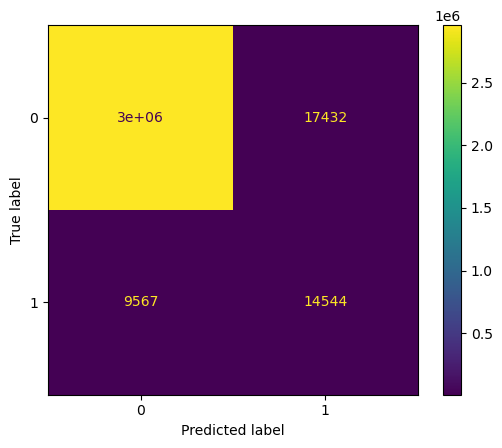

In [46]:
#Построим матрицу ошибок
cm=confusion_matrix(y_test, y_pred)
vis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
vis.plot()
plt.show()

In [47]:
Trained=True

**Вывод**

Получившаяся модель случайного леса досаточно точно определяет подходящий вектор, высокое значение ROC-AUC говорит, что модель гораздо чаще верно классифицирует вектор, чем ошибается.
Матрица конкретизирует какие именно ошибки совершает модель, например предлагает 1 в то время как эксперты поставили бы 0 или наоборот. Мы видим, что и здесь число ошибок не так и велико, и есть неплохая вероятность что модель сможет выбирать из предложенной faiss сотни векторов 5 наиболее подходящих даже луче чем сам faiss.

### Применение модели для выборки лучших кандидатов

In [48]:
#Пусть модель посчитает для каждого кандидата вероятность того, что это тот самый, одобренный экспертами
pr=pd.DataFrame(rfc.predict_proba(features))
df['predict']=pr[1]

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    5.1s remaining:   22.5s
[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed:    5.3s remaining:    4.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    5.5s finished


In [49]:
#Небольшая вспомогательная процедура, чтобы выбрать из датасета с помощью модели 5 наиболее вероятных кандидатов
def group_and_sort(df):
    return (df.sort_values('predict', ascending=False)
              .groupby('query_idx')
              .head(5))

In [50]:
sorted_df = group_and_sort(df)
winsound.Beep(200, 500)
idx=sorted_df.loc[:,['base_idx','query_idx','y']]

In [51]:
#Осталось только посчитать точность, достигнутую точность обесеченную моделью по метрика accuracy@5
hits = idx.groupby('query_idx')['y'].sum()
hits.sum()/(len(sorted_df['query_idx'].unique()))*100

76.24499999999999

**Вывод**

Теперь у нас есть индекс, генерирующий на каждый запрос по 100 соседних векторов из базы и обученная модель, выбирающая из них 5 подходящих кандидатов, таким образом что на обучающей базе целевая метриуа досигает 76.2%. Это является вполне неплохим результатом. Ведь если на каждый запрос пользователя предлагать ему пять других товаров, так что более чем в 3/4 случаев там будет один который ему точно понравится, это скорее всего будет способствовать росту продаж. Конечно тут многое будет зависеть от того, как эксперты разметили обучающий датасет, но над этим мы уже не властны.

### Проверка на валидационный выборке

Сначала сохраним в файлы с таким трудом полученные модели и данные, чтобы не пересчитывать их каждый раз заново.

In [53]:
if Trained==True and os.path.exists("idx_l2.index")==False:
    #Сохраним индекс
    idx_l3 = faiss.index_gpu_to_cpu(idx_l2)
    write_index(idx_l3, "idx_l2.index")
    #Сохраним спрессованные вектора признаков для широкой базы товаров
    merger.to_csv('vectors.csv')
    # Сохраним саму модель, выбирающую лучших кандидатов
    dump(rfc, 'rfc.joblib')

Сначала загрузим в файлы необходимые для работы модели:

In [54]:
#Мы обнаружили, что при подкачке векторов из csv они превращаются в строковый тип, чтобы это исправить напишем процедуру
def numpyfy(x):
    return np.fromstring(x, dtype=np.float32, sep=',')

In [55]:
if os.path.exists("idx_l2.index")==True:
    #Грузим индекс
    idx_l3= faiss.read_index("idx_l2.index")
    res = faiss.StandardGpuResources()
    idx_l2 = faiss.index_cpu_to_gpu(res, 0, idx_l3)
    #Грузим вектора
    merger=pd.read_csv('vectors.csv')
    #Мы обнаружили, что при подкачке векторов из csv они превращаются в строковый тип, исправим это
    merger['vector1'] =merger['vector1'].str[1:]
    merger['vector1'] =merger['vector1'].str[:-1]
    merger['vector1']=merger['vector1'].map(numpyfy)
    #Грузим модель
    rfc=load('rfc.joblib') 

In [56]:
# Загружаем валидационную выборку
dfv=pd.read_csv('validation.csv')
dfvy=pd.read_csv('validation_answer.csv')

In [57]:
dfv.head(7)

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.513020,52.830902,-143.43945,59.051935,69.28224,61.927513,111.592530,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.441830,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.077160,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.795410,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.636410,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.236110,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.183960,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.770250,45.635944,-134.25893,13.735359,70.61763,15.332115,154.568120,101.700640,-1171.892332,-125.307890
5,100005-query,-89.745360,6.317698,-80.744650,-114.53197,153.96034,-74.897130,-208.928691,-32.214005,115.582855,...,-64.934890,37.824436,-153.04173,-131.257912,68.26281,56.239280,120.646900,76.342550,-1156.992950,-72.146390
6,100006-query,-64.514260,7.711647,-28.726236,-220.05089,186.17746,-42.254353,96.324664,-30.496332,109.519530,...,-31.122826,11.672802,-112.34755,183.939297,67.22618,65.571060,-6.655426,95.882780,-1176.878727,-37.918420


Сначала пусть faiss сгенерирует нам 100 соседей для этого набора данных

In [58]:
ids=dfv['Id']
#Исключим столбцы с ненормальными распределениями
dfv=dfv.drop(['6','21','25','33','44','59','65','70','Id'], axis=1)
sc=StandardScaler()
#Проведём стандартизацию данных для лучших вычислений
df_train_sc=sc.fit_transform(dfv)
#Разделим тренировочную базу на кусочки, чтобы сделать процесс создания индекса более наблюдаемым
batches = np.array_split(df_train_sc, 1000)
start=time.time()
results = []
indices = []
for batch in tqdm(batches):
    #Здесь мы зададим поиск 100 соседей!
    r, idx = idx_l2.search(np.ascontiguousarray(batch).astype('float32'), 100)
    results.append(r)
    indices.append(idx)

# Concatenate the results and indices
r = np.concatenate(results)
idx = np.concatenate(indices)
end=time.time()
winsound.Beep(200, 500)
print(end-start)

  0%|          | 0/1000 [00:00<?, ?it/s]

83.2811849117279


In [59]:
df_idx = pd.DataFrame(idx)
df_r=pd.DataFrame(r)

In [60]:
#Создадим столбец с индексом запроса
df_idx['query_idx']=ids
value_vars_=list(df_idx.columns.values)[:-1]
# Мы можем "расплавить" этот DataFrame в длинный формат, так чтобы каждому запросу соответствовало 100 строк с каждым предложенным соседом
melted_df = pd.melt(df_idx, id_vars=['query_idx'], value_vars=value_vars_)

# Поскольку нам не нужен столбец "variable", мы можем его удалить
melted_df = melted_df.drop('variable', axis=1)
melted_df = melted_df.rename(columns={'value': 'idx'})
# Вывести итоговый DataFrame
melted_df.sort_values(by=['query_idx'])
melted_df

,query_idx,idx
0,100000-query,1954150
1,100001-query,1902634
2,100002-query,431806
3,100003-query,2171299
4,100004-query,1003744
...,...,...
9999995,199995-query,2828674
9999996,199996-query,475364
9999997,199997-query,1359038
9999998,199998-query,64276


In [61]:
df_r=pd.DataFrame(r)
df_r['query_idx_r']=ids
value_vars_=list(df_r.columns.values)[:-1]
# Мы можем "расплавить" этот и DataFrame в длинный формат
melted_r = pd.melt(df_r, id_vars=['query_idx_r'], value_vars=value_vars_)
# Поскольку нам не нужен столбец "variable", мы можем его удалить
melted_r = melted_r.drop('variable', axis=1)
melted_r = melted_r.rename(columns={'value': 'faiss_r'})
melted_r.sort_values(by=['query_idx_r'])
melted_r

,query_idx_r,faiss_r
0,100000-query,5.373446
1,100001-query,20.953814
2,100002-query,0.197787
3,100003-query,0.380278
4,100004-query,3.775987
...,...,...
9999995,199995-query,51.577225
9999996,199996-query,28.300457
9999997,199997-query,40.304844
9999998,199998-query,58.739689


In [62]:
df2 = pd.concat([melted_df, melted_r], axis=1)
df2 = df2.drop('query_idx_r', axis=1)
df2

,query_idx,idx,faiss_r
0,100000-query,1954150,5.373446
1,100001-query,1902634,20.953814
2,100002-query,431806,0.197787
3,100003-query,2171299,0.380278
4,100004-query,1003744,3.775987
...,...,...,...
9999995,199995-query,2828674,51.577225
9999996,199996-query,475364,28.300457
9999997,199997-query,1359038,40.304844
9999998,199998-query,64276,58.739689


In [63]:
#Присоединим их к нашему новому датасету для обучения модели
clz=dfv.columns.astype('str')
df_train_sc=pd.DataFrame(data=df_train_sc,columns=clz)
df_train_sc = pd.concat([df_train_sc, ids], axis=1)
df2 = df2.merge(df_train_sc, how='inner', left_on='query_idx', right_on='Id')
df2

,query_idx,idx,faiss_r,0,1,2,3,4,5,7,...,61,62,63,64,66,67,68,69,71,Id
0,100000-query,1954150,5.373446,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,1.778363,...,-1.436075,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query
1,100000-query,2192372,5.771656,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,1.778363,...,-1.436075,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query
2,100000-query,1225777,6.977925,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,1.778363,...,-1.436075,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query
3,100000-query,2504096,7.339772,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,1.778363,...,-1.436075,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query
4,100000-query,462353,7.507763,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,1.778363,...,-1.436075,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,199999-query,894172,37.290150,1.728065,-0.168856,0.353846,-0.497155,-0.058392,0.488591,-0.963909,...,0.756798,-0.010882,-0.329043,-0.470346,-0.539759,-0.418049,1.657282,0.735627,0.368066,199999-query
9999996,199999-query,2308608,37.307552,1.728065,-0.168856,0.353846,-0.497155,-0.058392,0.488591,-0.963909,...,0.756798,-0.010882,-0.329043,-0.470346,-0.539759,-0.418049,1.657282,0.735627,0.368066,199999-query
9999997,199999-query,2806558,37.341629,1.728065,-0.168856,0.353846,-0.497155,-0.058392,0.488591,-0.963909,...,0.756798,-0.010882,-0.329043,-0.470346,-0.539759,-0.418049,1.657282,0.735627,0.368066,199999-query
9999998,199999-query,1609918,37.390621,1.728065,-0.168856,0.353846,-0.497155,-0.058392,0.488591,-0.963909,...,0.756798,-0.010882,-0.329043,-0.470346,-0.539759,-0.418049,1.657282,0.735627,0.368066,199999-query


In [64]:
#Добавим вектор для каждого значения в общей базе
df2.columns = df2.columns.astype('str')
clz=dfv.columns.astype('str')
vec=df2[clz]
df2['vector2']=vec.iloc[:, :].values.tolist()

In [65]:
df2['vector2']=np.array(df2['vector2'])
df2.head(7)

,query_idx,idx,faiss_r,0,1,2,3,4,5,7,...,62,63,64,66,67,68,69,71,Id,vector2
0,100000-query,1954150,5.373446,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782..."
1,100000-query,2192372,5.771656,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782..."
2,100000-query,1225777,6.977925,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782..."
3,100000-query,2504096,7.339772,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782..."
4,100000-query,462353,7.507763,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782..."
5,100000-query,342838,7.673828,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782..."
6,100000-query,999102,7.869899,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,0.182992,0.631299,0.215821,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782..."


In [77]:
#проведём слияние датафреймов, чтобы в нашей базе данных для обучения оказались оба вектора для каждого запроса
df2= df2.merge(merger, how='inner', left_on='idx', right_on='Id')
winsound.Beep(200, 500)
df2.head(7)

,query_idx,idx,faiss_r,0,1,2,3,4,5,7,...,66,67,68,69,71,Id_x,vector2,Unnamed: 0,Id_y,vector1
0,100000-query,1954150,5.373446,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,1.778363,...,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,..."
1,120863-query,1954150,41.133289,1.535025,-1.365847,1.801887,-0.120847,0.237084,-1.120499,1.232555,...,1.088348,0.994015,-1.096939,1.210433,-0.554222,120863-query,"[1.5350252195919287, -1.365847101730844, 1.801...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,..."
2,161086-query,1954150,26.116188,0.533892,-1.398753,0.350029,0.512501,0.036131,-0.909322,1.951006,...,0.265928,1.263078,0.679475,-0.047539,-0.171306,161086-query,"[0.5338923982425358, -1.3987526579185052, 0.35...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,..."
3,163749-query,1954150,28.748049,1.011989,-1.403876,1.759421,-0.358963,0.389177,-1.052354,1.383439,...,0.626657,0.995010,-1.016821,1.173944,-0.875870,163749-query,"[1.0119893134440765, -1.403876123283706, 1.759...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,..."
4,164625-query,1954150,43.404312,0.576050,0.474490,0.692239,0.540579,0.562028,-1.924107,0.149582,...,0.948629,1.202850,-0.173433,-0.696190,-0.812345,164625-query,"[0.5760504423785574, 0.4744902335242684, 0.692...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,..."
5,196770-query,1954150,7.269785,0.569702,-0.369423,1.071118,0.912459,0.133342,-0.220167,1.291127,...,0.474921,0.546898,0.372167,0.556221,-1.353567,196770-query,"[0.5697018067434333, -0.36942255422811954, 1.0...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,..."
6,100000-query,2192372,5.771656,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,1.778363,...,0.809616,0.698091,0.620055,-0.002618,-1.662841,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782...",2192372,2192372,"[1.1296766, -0.2730103, 0.64170873, 1.0217724,..."


In [87]:
df2['evql']=0
df2['mnh']=0
df2['chbsh']=0
df2['cos']=0
for i in trange(len(df2)):
    vector1=np.ascontiguousarray(df2['vector1'][i]).astype('float32')
    vector2=np.ascontiguousarray(df2['vector2'][i]).astype('float32')
    #Евклидово расстояние
    df2['evql'][i]=np.linalg.norm(vector1-vector2)
    #Манхэттенское расстояние
    df2['mnh'][i]=np.sum(np.abs(vector1-vector2))
    #Расстояние Чебышева 
    df2['chbsh'][i]=np.abs(vector1-vector2).max()
    #Косинус включенного угла
    df2['cos'][i]=(np.dot(vector1,vector2)/(np.linalg.norm(vector1)*(np.linalg.norm(vector2)))).astype('float32')
winsound.Beep(200, 500)
df2.head(7)

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [08:40<00:00, 19212.70it/s]


,query_idx,idx,faiss_r,0,1,2,3,4,5,7,...,71,Id_x,vector2,Unnamed: 0,Id_y,vector1,evql,mnh,chbsh,cos
0,100000-query,1954150,5.373446,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,1.778363,...,-1.662841,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",2.318069,14.984797,0.724992,0.961499
1,120863-query,1954150,41.133289,1.535025,-1.365847,1.801887,-0.120847,0.237084,-1.120499,1.232555,...,-0.554222,120863-query,"[1.5350252195919287, -1.365847101730844, 1.801...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",6.413523,39.458473,2.092127,0.707417
2,161086-query,1954150,26.116188,0.533892,-1.398753,0.350029,0.512501,0.036131,-0.909322,1.951006,...,-0.171306,161086-query,"[0.5338923982425358, -1.3987526579185052, 0.35...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",5.110400,32.919746,1.572800,0.804468
3,163749-query,1954150,28.748049,1.011989,-1.403876,1.759421,-0.358963,0.389177,-1.052354,1.383439,...,-0.875870,163749-query,"[1.0119893134440765, -1.403876123283706, 1.759...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",5.361721,33.482368,1.871837,0.797228
4,164625-query,1954150,43.404312,0.576050,0.474490,0.692239,0.540579,0.562028,-1.924107,0.149582,...,-0.812345,164625-query,"[0.5760504423785574, 0.4744902335242684, 0.692...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",6.588195,41.888954,3.032949,0.677955
5,196770-query,1954150,7.269785,0.569702,-0.369423,1.071118,0.912459,0.133342,-0.220167,1.291127,...,-1.353567,196770-query,"[0.5697018067434333, -0.36942255422811954, 1.0...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",2.696254,17.163267,0.829162,0.946858
6,100000-query,2192372,5.771656,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,1.778363,...,-1.662841,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782...",2192372,2192372,"[1.1296766, -0.2730103, 0.64170873, 1.0217724,...",2.402427,15.743315,0.674335,0.960688


In [88]:
df2['base_idx'] = df2['idx'].astype('str') + "-base"
df2.head(9)

,query_idx,idx,faiss_r,0,1,2,3,4,5,7,...,Id_x,vector2,Unnamed: 0,Id_y,vector1,evql,mnh,chbsh,cos,base_idx
0,100000-query,1954150,5.373446,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,1.778363,...,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",2.318069,14.984797,0.724992,0.961499,1954150-base
1,120863-query,1954150,41.133289,1.535025,-1.365847,1.801887,-0.120847,0.237084,-1.120499,1.232555,...,120863-query,"[1.5350252195919287, -1.365847101730844, 1.801...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",6.413523,39.458473,2.092127,0.707417,1954150-base
2,161086-query,1954150,26.116188,0.533892,-1.398753,0.350029,0.512501,0.036131,-0.909322,1.951006,...,161086-query,"[0.5338923982425358, -1.3987526579185052, 0.35...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",5.110400,32.919746,1.572800,0.804468,1954150-base
3,163749-query,1954150,28.748049,1.011989,-1.403876,1.759421,-0.358963,0.389177,-1.052354,1.383439,...,163749-query,"[1.0119893134440765, -1.403876123283706, 1.759...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",5.361721,33.482368,1.871837,0.797228,1954150-base
4,164625-query,1954150,43.404312,0.576050,0.474490,0.692239,0.540579,0.562028,-1.924107,0.149582,...,164625-query,"[0.5760504423785574, 0.4744902335242684, 0.692...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",6.588195,41.888954,3.032949,0.677955,1954150-base
5,196770-query,1954150,7.269785,0.569702,-0.369423,1.071118,0.912459,0.133342,-0.220167,1.291127,...,196770-query,"[0.5697018067434333, -0.36942255422811954, 1.0...",1954150,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",2.696254,17.163267,0.829162,0.946858,1954150-base
6,100000-query,2192372,5.771656,1.083497,-0.821465,0.782574,0.985244,-0.018620,-0.280778,1.778363,...,100000-query,"[1.083496558945189, -0.8214648557426717, 0.782...",2192372,2192372,"[1.1296766, -0.2730103, 0.64170873, 1.0217724,...",2.402427,15.743315,0.674335,0.960688,2192372-base
7,163749-query,2192372,39.226849,1.011989,-1.403876,1.759421,-0.358963,0.389177,-1.052354,1.383439,...,163749-query,"[1.0119893134440765, -1.403876123283706, 1.759...",2192372,2192372,"[1.1296766, -0.2730103, 0.64170873, 1.0217724,...",6.263134,40.600708,1.906924,0.733068,2192372-base
8,196770-query,2192372,8.408564,0.569702,-0.369423,1.071118,0.912459,0.133342,-0.220167,1.291127,...,196770-query,"[0.5697018067434333, -0.36942255422811954, 1.0...",2192372,2192372,"[1.1296766, -0.2730103, 0.64170873, 1.0217724,...",2.899752,18.994127,0.799854,0.942157,2192372-base


In [89]:
dfvy.head()

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


In [90]:
df2=df2.merge(dfvy, how='inner', left_on='query_idx', right_on='Id')
df2['y']= df2['Expected'] == df2['base_idx']
df2['y']=df2['y'].astype('int')


In [91]:
df2.head(5)

,query_idx,idx,faiss_r,0,1,2,3,4,5,7,...,Id_y,vector1,evql,mnh,chbsh,cos,base_idx,Id,Expected,y
0,100000-query,1954150,5.373446,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,1954150,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",2.318069,14.984797,0.724992,0.961499,1954150-base,100000-query,2676668-base,0
1,100000-query,2192372,5.771656,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,2192372,"[1.1296766, -0.2730103, 0.64170873, 1.0217724,...",2.402427,15.743315,0.674335,0.960688,2192372-base,100000-query,2676668-base,0
2,100000-query,1225777,6.977925,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,1225777,"[1.1141577, -0.48878863, 1.0102031, 1.0896583,...",2.641576,17.606186,0.780773,0.950579,1225777-base,100000-query,2676668-base,0
3,100000-query,2504096,7.339772,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,2504096,"[1.1147466, -0.31610367, 1.4728781, 1.0546768,...",2.709201,17.573734,0.690304,0.950442,2504096-base,100000-query,2676668-base,0
4,100000-query,462353,7.507763,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,462353,"[0.7355282, -0.054708574, 1.2956927, 0.7573616...",2.740030,17.417667,0.802310,0.947592,462353-base,100000-query,2676668-base,0


In [92]:
keep_list=rfc.feature_names_in_
features=df2.loc[:,keep_list]

In [93]:
features

,evql,mnh,faiss_r,cos,chbsh,51,4,9,2,18
0,2.318069,14.984797,5.373446,0.961499,0.724992,-0.214079,-0.018620,-0.781536,0.782574,-1.590451
1,2.402427,15.743315,5.771656,0.960688,0.674335,-0.214079,-0.018620,-0.781536,0.782574,-1.590451
2,2.641576,17.606186,6.977925,0.950579,0.780773,-0.214079,-0.018620,-0.781536,0.782574,-1.590451
3,2.709201,17.573734,7.339772,0.950442,0.690304,-0.214079,-0.018620,-0.781536,0.782574,-1.590451
4,2.740030,17.417667,7.507763,0.947592,0.802310,-0.214079,-0.018620,-0.781536,0.782574,-1.590451
...,...,...,...,...,...,...,...,...,...,...
9999995,0.422341,2.525403,0.178372,0.997054,0.195351,0.357820,0.560254,-0.435954,0.383585,1.479923
9999996,0.422341,2.525403,0.178372,0.997054,0.195351,0.357820,0.560254,-0.435954,0.383585,1.479923
9999997,0.422341,2.525403,0.178372,0.997054,0.195351,0.357820,0.560254,-0.435954,0.383585,1.479923
9999998,0.422341,2.525403,0.178372,0.997054,0.195351,0.357820,0.560254,-0.435954,0.383585,1.479923


In [94]:
pr=pd.DataFrame(rfc.predict_proba(features))
df2['predict']=pr[1]


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    4.3s remaining:   18.9s
[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed:    4.5s remaining:    3.5s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    4.8s finished


In [95]:
df2.head(9)

,query_idx,idx,faiss_r,0,1,2,3,4,5,7,...,vector1,evql,mnh,chbsh,cos,base_idx,Id,Expected,y,predict
0,100000-query,1954150,5.373446,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,"[1.3988637, -1.0908535, 1.1643575, 0.70641327,...",2.318069,14.984797,0.724992,0.961499,1954150-base,100000-query,2676668-base,0,0.8125
1,100000-query,2192372,5.771656,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,"[1.1296766, -0.2730103, 0.64170873, 1.0217724,...",2.402427,15.743315,0.674335,0.960688,2192372-base,100000-query,2676668-base,0,0.3125
2,100000-query,1225777,6.977925,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,"[1.1141577, -0.48878863, 1.0102031, 1.0896583,...",2.641576,17.606186,0.780773,0.950579,1225777-base,100000-query,2676668-base,0,0.3750
3,100000-query,2504096,7.339772,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,"[1.1147466, -0.31610367, 1.4728781, 1.0546768,...",2.709201,17.573734,0.690304,0.950442,2504096-base,100000-query,2676668-base,0,0.2500
4,100000-query,462353,7.507763,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,"[0.7355282, -0.054708574, 1.2956927, 0.7573616...",2.740030,17.417667,0.802310,0.947592,462353-base,100000-query,2676668-base,0,0.5000
5,100000-query,342838,7.673828,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,"[0.90020305, -0.37139344, 1.0172982, 1.2332324...",2.770168,18.051228,0.824171,0.943854,342838-base,100000-query,2676668-base,0,0.4375
6,100000-query,999102,7.869899,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,"[1.120756, -0.3210602, 1.1316725, 0.83589405, ...",2.805334,18.383642,0.917425,0.944372,999102-base,100000-query,2676668-base,0,0.5625
7,100000-query,340288,8.267381,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,"[1.0790297, -1.3213681, 0.91659534, 0.8646149,...",2.875305,19.263069,0.800671,0.941868,340288-base,100000-query,2676668-base,0,0.4375
8,100000-query,814942,8.286588,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,...,"[1.0459008, -0.27348623, 0.9891567, 0.9128366,...",2.878643,18.521557,0.872183,0.941441,814942-base,100000-query,2676668-base,0,0.3125


In [96]:
#Небольшая вспомогательная процедура, чтобы выбрать из датасета с помощью модели 5 наиболее вероятных кандидатов
def group_and_sort(df):
    return (df.sort_values('predict', ascending=False)
              .groupby('query_idx')
              .head(5))

In [97]:
sorted_df = group_and_sort(df2)
winsound.Beep(200, 500)


In [98]:
idx=sorted_df.loc[:,['base_idx','query_idx','y']]

In [99]:
#Осталось только посчитать точность, достигнутую точность обесеченную моделью по метрике accuracy@5
hits = idx.groupby('query_idx')['y'].sum()
hits.sum()/(len(sorted_df['query_idx'].unique()))*100

0.134

**Вывод**

- Вывод неутешительный. Либор валидационная выборка настолько сильно отличается, либо модель переобучилась, либо индекс плохо составился, но целевая метрика на данных, неизвестных модели, оказалось крайне низкой.
- Было потрачено очень много времени, и проведены многочисленные вычисления, не давшие никакого полезного результата. Использование подобной модели не даст хороших рекомендаций клиентам, и не будет способствовать заметному приросту продаж маркетплейса.
- Также следует тометить что объёмы вычислений, небоходимых для подготовки данных из переданной заказчиком формы в данные для предсказания, крайне велик и требователен к машинным ресурсам.
- Видимо эта задача оказалась слишком сложной для меня на текущем уровне, и самое печальное, что я даже не понимаю что можно было бы улучшить, чтобы к моменту окончания Мастерской показать результаты лучше.